In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from time import sleep

In [2]:
import brian2 as b2
import pickle

In [3]:
import pandas as pd

In [4]:
with open('output/saved.pickle', 'rb') as f:
    saveobj = pickle.load(f)

Need efficient code using saveobj to do the following:

* check input spike train by visualising spikes for a few examples and comparing to label
* visualise spikes in processing layer excitory and inhibitory neurons
* plot distributions of spiking rates in processing layer excitory neurons
* identify assignments between processing layer excitory neurons and labels
* get prediction (and 'strength' = spike rate) for each example

In [5]:
saveobj

{'rate_monitors': {'Ae': {'rate': array([0., 0., 0., ..., 0., 0., 0.]) * hertz,
   't': array([0.0000000e+00, 5.0000000e-04, 1.0000000e-03, ..., 4.9999985e+03,
          4.9999990e+03, 4.9999995e+03]) * second,
   'N': array(0, dtype=int32)},
  'Ai': {'rate': array([0., 0., 0., ..., 0., 0., 0.]) * hertz,
   't': array([0.0000000e+00, 5.0000000e-04, 1.0000000e-03, ..., 4.9999985e+03,
          4.9999990e+03, 4.9999995e+03]) * second,
   'N': array(0, dtype=int32)},
  'Xe': {'rate': array([ 5.10204082,  5.10204082, 12.75510204, ...,  0.        ,
           0.        ,  0.        ]) * hertz,
   't': array([0.0000000e+00, 5.0000000e-04, 1.0000000e-03, ..., 4.9999985e+03,
          4.9999990e+03, 4.9999995e+03]) * second,
   'N': array(0, dtype=int32)}},
 'spike_monitors': {'Ae': {'i': array([224, 234,   3, ..., 201, 272, 325], dtype=int32),
   't': array([5.4000000e-02, 5.4000000e-02, 5.4500000e-02, ..., 4.9998835e+03,
          4.9998835e+03, 4.9998835e+03]) * second,
   'count': array([ 

In [6]:
from matplotlib import animation, rc
from IPython.display import Image
rc('animation', html='html5')

# convert time to integers in units of 0.1 ms
dfp = {}
for p in saveobj['spike_monitors']: 
    dfp[p] = pd.DataFrame({'t': (saveobj['spike_monitors'][p]['t'] / (0.1*b2.ms)).astype(np.int),
                           'i'.format(p): saveobj['spike_monitors'][p]['i']})

# bins of 0.5s, i.e. one example
n_e = 400
imgsize = 28
total_example_time = saveobj['total_example_time']
for p in dfp:
    dfp[p]['tbin'] = (dfp[p]['t'] * 0.1*b2.ms / total_example_time).astype(np.int)
    if 'X' in p:
        dfp[p]['x'] = dfp[p]['i'] % imgsize
        dfp[p]['y'] = dfp[p]['i'] // imgsize

countsp = {p: dfp[p].groupby(['tbin', 'i'])['t'].count().rename('count') for p in dfp}

def spike_animation(example_number=None,
                    gif_filename='spikes_example',
                    max_counts=50):
    if example_number is None:
        example_number = np.random.choice(dfp['Xe']['tbin'])
    dfp_ex = {p: dfp[p].set_index('tbin').loc[example_number] for p in dfp}
    dtexbin = 5 * b2.ms
    for p in dfp:
        dfp_ex[p]['texbin'] = ((dfp_ex[p]['t'] - dfp_ex[p]['t'].min()) / 50).astype(np.int)
    counts_ex = dfp_ex['Xe'].groupby(['texbin', 'x', 'y'])['t'].count().reset_index(level=['x', 'y'])

    tott = total_example_time / dtexbin
    times = np.arange(tott)
    
    fig, (axX, axA) = plt.subplots(1, 2, figsize=(15, 5))
    img = axX.imshow(np.zeros((imgsize, imgsize)),
                     vmin=0, vmax=max_counts)
    dotsX, = axX.plot([], [], 'r.')
    title = axX.set_title('', loc='right')
    axX.axis('off')
    
    dotsAe, = axA.plot([], [], 'r.')
    dotsAi, = axA.plot([], [], 'bo', mfc='none')
    axA.set_xlim(-1, tott * dtexbin/b2.ms)
    axA.set_ylim(-1, n_e)
    axA.set_xlabel('$t$ (ms)')
    axA.set_ylabel('neuron index')
    lineA, = axA.plot([], [], 'k-')
    fig.set_tight_layout(True)
    
    def init():
        a = img.get_array()
        a[:] *= 0
        dotsX.set_data([], [])
        dotsAe.set_data([], [])
        dotsAi.set_data([], [])
        title.set_text('')
        return [title, dotsX, dotsAe, dotsAi, lineA, img]

    def animate(t):
        artists = [title, dotsX, dotsAe, dotsAi, lineA]
        ti = dtexbin/b2.ms * (t+1)
        title.set_text('{} ms'.format(ti))
        if t in counts_ex.index:
            artists.append(img)
            k = counts_ex.loc[t]
            a = img.get_array()
            a[k['y'], k['x']] += 1
            dotsX.set_data(k['x'], k['y'])
        else:
            dotsX.set_data([], [])

        lineA.set_data([ti, ti], [-1, n_e])

        Ai_spikes = dfp_ex['Ai'][dfp_ex['Ai']['texbin'] <= t]
        dotsAi.set_data(Ai_spikes['texbin'] * dtexbin/b2.ms, Ai_spikes['i'])
        Ae_spikes = dfp_ex['Ae'][dfp_ex['Ae']['texbin'] <= t]
        dotsAe.set_data(Ae_spikes['texbin'] * dtexbin/b2.ms, Ae_spikes['i'])
        return artists

    duration = 10000  # ms
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=times, interval=duration/len(times),
                                   repeat=False, blit=True)
    plt.close()
    if gif_filename is not None:
        anim.save('{}.gif'.format(gif_filename), writer='imagemagick', fps=1000*len(times)/duration)
    return anim

In [7]:
anim = spike_animation()

In [8]:
Image(url='processing_spikes_example.gif')

In [9]:
def plot_spike_distribution(counts):
    counts_mean = counts.groupby('i').mean()
    counts_std = counts.groupby('i').std()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.hist(counts_mean)
    ax1.set_xlabel('spikes per example');
    ax2.errorbar(counts_mean.index, counts_mean, counts_std, marker='', linestyle='none')
    ax2.set_xlabel('neuron index')
    ax2.set_ylabel('spikes per example');

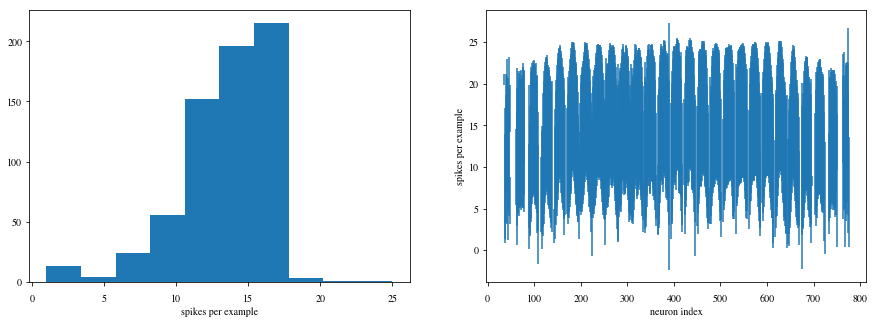

In [10]:
plot_spike_distribution(countsp['Xe'])

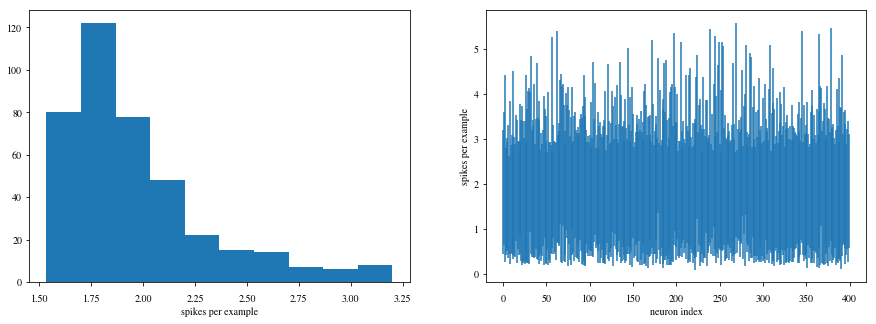

In [11]:
plot_spike_distribution(countsp['Ae'])

In [12]:
labels = pd.DataFrame({'label': saveobj['labels']}).rename_axis('tbin')

In [13]:
counts = countsp['Ae']
counts = labels.join(counts)
counts = counts.reset_index('tbin', drop=True)
counts = counts.groupby(['i', 'label']).mean().reset_index('label')
counts = counts.sort_values(['i', 'count'], ascending=[True, False])
assignments = counts.groupby('i').head(1).drop(columns='count')

In [18]:
len(labels), len(assignments)

(10000, 400)

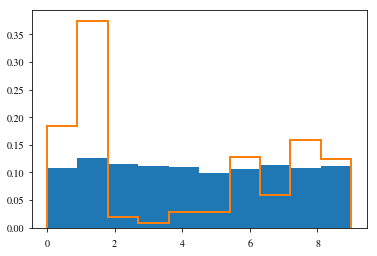

In [22]:
plt.hist(labels['label'], normed=True)
plt.hist(assignments['label'], normed=True, histtype='step', lw=2);

In [96]:
def get_assignments(counts, labels):
    counts = labels.join(counts)
    counts = counts.reset_index('tbin', drop=True)
    counts = counts.groupby(['i', 'label']).mean().reset_index('label')
    counts = counts.sort_values(['i', 'count'], ascending=[True, False])
    assignments = counts.groupby('i').head(1).drop(columns='count')
    return assignments

In [98]:
assignments = get_assignments(countsp['Ae'], labels)

In [99]:
assignments

,label
i,
0,9
1,4
2,0
3,0
4,4
5,8
6,0
7,3
8,0


In [100]:
#def get_predictions(counts, assignments):
counts = countsp['Ae']
counts = pd.DataFrame(assignments).join(counts)

In [101]:
counts.head(20)

label  count
tbin i                
0    3        0      1
     34       7      3
     63       0      6
     123      5      1
     179      7      1
     190      0      1
     198      3      1
     217      0      2
     224      2      2
     234      7      5
     276      8      4
     278      8      4
     288      7      6
     352      3      1
1    1        4      1
     5        8      1
     15       6      1
     19       9      1
     34       7      1
     37       8      1

In [102]:
counts = counts.groupby(['tbin', 'label']).mean()

In [103]:
counts = counts.sort_values(['tbin', 'count'], ascending=[True, False])

In [104]:
predictions = counts.groupby(['tbin']).head(1)

In [105]:
predictions

,,count
tbin,label,
0,8,4.000000
1,2,2.600000
2,8,6.000000
3,1,2.500000
4,9,4.000000
5,2,6.500000
6,8,6.000000
7,7,6.000000
8,1,3.000000


In [106]:
predictions.join(labels)

,,count,label
tbin,label,,
0,8,4.000000,7
1,2,2.600000,2
2,8,6.000000,1
3,1,2.500000,0
4,9,4.000000,4
5,2,6.500000,1
6,8,6.000000,4
7,7,6.000000,9
8,1,3.000000,5


In [31]:
inputLabels = np.load('../stdp-mnist/activity/inputNumbers10000.npy')

In [34]:
resultPopVecs = np.load('../stdp-mnist/activity/resultPopVecs10000.npy').astype(np.int)

In [44]:
(inputLabels == labels['label']).all()

True

In [94]:
x = pd.DataFrame(columns=['tbin', 'i', 'count'])

for i in np.arange(10000):
    df = pd.DataFrame({'tbin': i, 'i': np.arange(400), 'count': resultPopVecs[i]})
    df = df[df['count'] > 0]
    x.append(df)

In [95]:
x

,tbin,i,count


In [60]:
x[x> 0]

40     3
174    4
219    3
dtype: int64

In [54]:
countsp['Ae'][0]

i
3      1
34     3
63     6
123    1
179    1
190    1
198    1
217    2
224    2
234    5
276    4
278    4
288    6
352    1
Name: count, dtype: int64